## PG_modeling_LR_SVM_learning_curves.ipynb

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve,roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, label_binarize

In [152]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/code/functions')
from gis_processing import *
import pickle

## Data Import
### county grid

In [153]:
project_dir = '/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/'
data_dir = os.path.join(project_dir, "data")

### Target/Feature DF

In [154]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))


target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)
target_df

,GRID_ID,month_id,MONTH,COUNTYFP,NAME,GRID_AREA,Y_bin,Y_fire_count,Fire_area,elev_mean,...,tot_prcp_12hrs_10y,tot_prcp_18hrs_10y,Y_bin_new_fire_month,Y_count_new_fires_month,Y_max_new_fire_size_month,YEAR,Y_fire_class_size,geometry,Y_fire_area_prop,month_id_old
0,0,1990_10,10,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.001730,0.002638,0,5,0,1990,0,None,0.0,1990_9
1,0,1990_11,11,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.005466,0.007901,0,3,0,1990,0,None,0.0,1990_10
2,0,1990_12,12,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004499,0.007008,0,2,0,1990,0,None,0.0,1990_11
3,0,1990_2,2,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004638,0.006698,0,0,0,1990,0,None,0.0,1990_1
4,0,1990_3,3,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004855,0.006756,0,2,0,1990,0,None,0.0,1990_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47383,147,2019_5,5,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000013,0.000022,0,0,0,2019,0,None,0.0,2019_4
47384,147,2019_6,6,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000001,0.000003,0,0,0,2019,0,None,0.0,2019_5
47385,147,2019_7,7,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000112,0.000154,0,0,0,2019,0,None,0.0,2019_6
47386,147,2019_8,8,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000093,0.000185,0,0,0,2019,0,None,0.0,2019_7


#### Feature Lists

In [5]:
RF_entropy_top30_features = pd.read_pickle(os.path.join(project_dir, 'models/feature_lists/RF_entropy_top30_features.pkl'))
# RF_gini_top20_features = pd.read_pickle(os.path.join(project_dir, 'models/feature_lists/RF_gini_top20_features.pkl'))

In [6]:
non_mod_cols = ['GRID_ID','month_id','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']
        
target_df_working = target_df

In [7]:
non_mod_cols_PCA = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count', 'adj_fire_bcount']
Y_cols_PCA = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

## Train- test Split

#### select feature and normalize (RF Feature List)

In [158]:
target_model_df=target_df
target_feat = "Y_bin_new_fire_month"
feature_filter = RF_entropy_top30_features

target_model_df[feature_filter] = pd.DataFrame(scale(target_model_df[feature_filter]), columns = feature_filter)
full_time_series_df = target_model_df[["YEAR"] + ["MONTH"] + [target_feat] + feature_filter]

#### Split data into train and test sets (RF Reature List)

In [172]:
train_data_RF = full_time_series_df[(target_model_df['YEAR']>=1990) & (target_model_df['YEAR']<=2016)]
test_data_RF = full_time_series_df[target_model_df['YEAR']>2016]

#### Select feature and normalize (PCA)

In [173]:
X_features = target_df.copy()
for y in Y_cols + non_mod_cols:
    try:
        X_features.drop(y, inplace = True, axis =1)
    except:
        pass

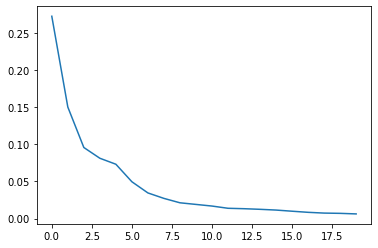

In [174]:
X_features_scaled = scale(X_features)
pca = PCA()
pca_x = pca.fit(X_features_scaled)
plt.plot(pca_x.explained_variance_ratio_[0:20])

In [175]:
pca_top15_comp = df = pd.DataFrame(pca_x.components_[0:15,].transpose(), columns = ["PC{}".format(i+1) for i in range(15)], \
                      index = X_features.columns)

X_features_pca = pd.DataFrame(pca_x.transform(X_features_scaled), columns = ["PC{}".format(i+1) for i in range(len(pca_x.explained_variance_ratio_))])
X_features_pca_top20 = X_features_pca[["PC{}".format(i+1) for i in range(15)]]
full_time_series_df_PCA = target_model_df[["YEAR"] + ["MONTH"] + [target_feat]].join(X_features_pca_top20)
full_time_series_df_PCA

,YEAR,MONTH,Y_bin_new_fire_month,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,1990,10,0,0.512414,-4.078907,2.948293,-6.154855,-6.738716,3.924684,-0.792917,-2.258680,-2.468627,1.221661,1.690469,-1.580008,-1.884973,2.117231,1.133977
1,1990,11,0,-3.671503,-6.351653,6.844954,-7.272768,-3.931153,2.825678,-1.265431,-0.857818,-2.320526,2.047628,1.077163,-0.417463,-0.860837,1.893029,1.212168
2,1990,12,0,-5.290914,-5.038433,6.896796,-7.282031,-2.391392,1.878012,-0.050205,-1.649951,-2.325478,0.903558,0.948985,-0.640680,-0.667169,1.813254,1.970981
3,1990,2,0,-6.537297,-6.918015,8.463189,-7.000747,-1.506237,2.728272,-3.482025,-0.398837,-1.324503,0.928085,-3.554928,1.010770,2.021197,2.441221,0.481682
4,1990,3,0,-6.782533,-8.009353,8.902348,-8.806774,-0.553210,2.706603,-6.779196,1.256998,-1.051955,4.525263,1.126989,-0.374065,-1.947811,2.783441,-2.870647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47383,2019,5,0,0.823072,11.976738,3.471943,0.529479,0.647854,0.362147,0.480331,-0.726720,-0.079333,0.820583,-0.341667,1.727981,-0.808469,1.214264,-1.769401
47384,2019,6,0,1.322588,13.078748,1.631662,-2.106538,0.939788,-0.538099,-0.169502,-0.384422,-0.538273,1.490752,-0.971679,2.487088,-0.832339,1.273587,-1.737207
47385,2019,7,0,3.080459,13.072146,0.318197,-6.327675,0.824703,-1.907596,-0.580350,0.565245,-1.352428,2.853916,-0.462274,2.345059,-1.673094,1.210703,-0.973603
47386,2019,8,0,3.141965,13.171337,0.245479,-6.429990,0.888310,-1.918208,-0.512722,0.349521,-1.288249,2.844642,-0.503161,2.578245,-1.193222,1.242666,-0.502430


#### Split data into train and test sets (PCA top 16)

In [176]:
train_data_PCA= full_time_series_df_PCA[(full_time_series_df_PCA['YEAR']>=1990) & (full_time_series_df_PCA['YEAR']<=2016)]
test_data_PCA= full_time_series_df_PCA[full_time_series_df_PCA['YEAR']>2016]

In [177]:
with open(os.path.join(project_dir,'models/LR_15PCA_1990_2015.pkl'), 'rb') as f:
    model = pickle.load(f)

In [178]:
LR_model_dict ={}
models_path = os.path.join(project_dir,'models')
for filename in os.listdir(models_path):
    if filename.startswith("LR"):
        with open(os.path.join(models_path,filename), 'rb') as f:
            LR_model_dict[filename[:-4]] = pickle.load(f)
    else:
        continue
        
LR_model_dict

{'LR_30entropy_1990_2015': LogisticRegression(C=0.001, class_weight='balanced'),
 'LR_30entropy_1990_2005': LogisticRegression(C=0.001, class_weight='balanced'),
 'LR_15PCA_1990_2015': LogisticRegression(C=0.001, class_weight='balanced'),
 'LR_20gini_1990_2005': LogisticRegression(C=0.001, class_weight='balanced'),
 'LR_15PCA_1990_2005': LogisticRegression(C=0.0001, class_weight='balanced')}

In [184]:
dataset = train_data
label_name = "Y_bin_new_fire_month"

def simp_learning_curve_model(dataset, label_name, model, model_name,title):
    years_list = []
    years_unique = dataset.YEAR.unique()
    AUC_dict_train = {}
    AUC_dict_test = {}


    for year in years_unique[:-1]:
        train_fold = dataset[dataset["YEAR"] <= year].drop(["YEAR","MONTH"],axis=1)
        validation_fold = dataset[dataset["YEAR"] == year+1].drop(["YEAR","MONTH"],axis=1)
#         print(year,len(train_fold),len(validation_fold))

        LR_ts_kfold = model.fit(train_fold.drop(label_name, 1),train_fold[label_name])
        AUC_search_test = roc_auc_score(validation_fold[label_name], LR_ts_kfold.predict_proba(validation_fold.drop(label_name,1))[:,1])
        AUC_search_train = roc_auc_score(train_fold[label_name], LR_ts_kfold.predict_proba(train_fold.drop(label_name,1))[:,1])


    #     recall_search = recall_score(validation_fold[label_name], LR_ts_kfold.predict(validation_fold.drop(label_name,1)))
    #     precision_search = precision_score(validation_fold[label_name], LR_ts_kfold.predict(validation_fold.drop(label_name,1)))

        AUC_dict_train[year] = AUC_search_train
        AUC_dict_test[year] =AUC_search_test
    learning_val = pd.DataFrame([AUC_dict_test, AUC_dict_train]).T
    learning_val = learning_val.reset_index()
    learning_val.columns = ["Year","Test","Train"]

    plt.show()
    plt.plot(learning_val["Year"],learning_val["Test"],label = "test")
    plt.plot(learning_val["Year"],learning_val["Train"], label = "train")
    plt.title(model_name+title)
    plt.legend()

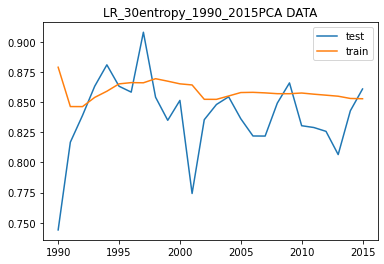

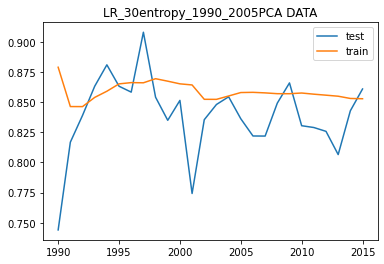

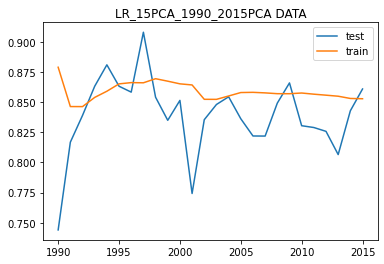

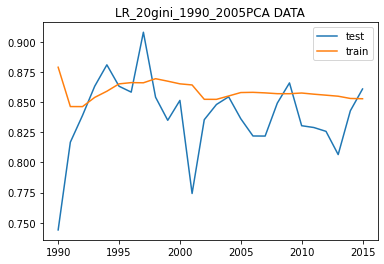

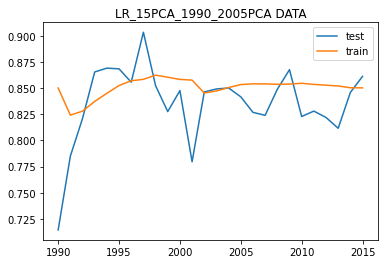

In [185]:
for model in LR_model_dict:
    simp_learning_curve_model(train_data_PCA, label_name, LR_model_dict[model],model,"PCA DATA")

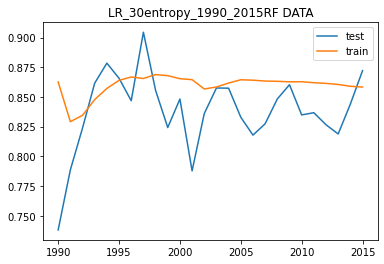

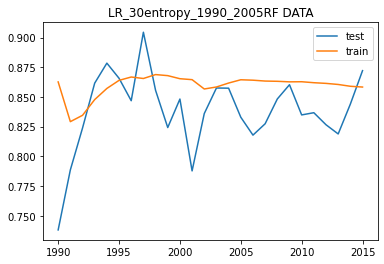

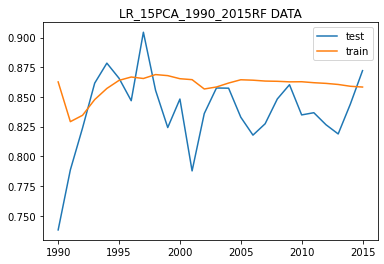

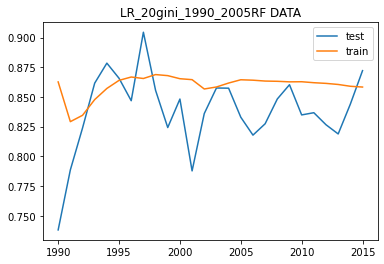

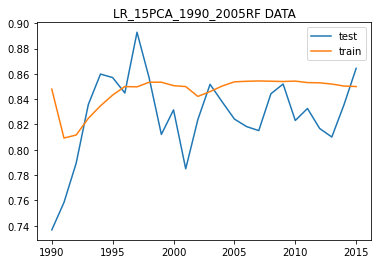

In [186]:
for model in LR_model_dict:
    simp_learning_curve_model(train_data_RF, label_name, LR_model_dict[model],model,"RF DATA")

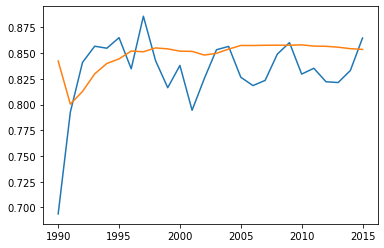

In [134]:
simp_learning_curve(dataset, label_name, c)

In [132]:
# def bootstrap_ts_learning_curve

dataset = train_data
label_name = "Y_bin_new_fire_month"
c = .001

years_unique = dataset.YEAR.unique()
for i in range(1,len(years_unique)):
    for j in range(years_unique[:-1]:
        pass#print(j)
#     for segment_size in int(years_unique/i):
#         print(segment_size)


SyntaxError: invalid syntax (<ipython-input-132-412d94f77b20>, line 9)